### Import Libraries

In [1]:
import pandas as pd
import numpy as mp
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import statsmodels.api as sm
import matplotlib.pyplot as plt

### Load in Test and Validation Datasets

In [2]:
## Load in Test Set
X_test_path = "/Users/claudia/DSA4262-ACMXZ/data/preprocessed_data/X_test_enc.parquet"
X_test = pd.read_parquet(X_test_path)

y_test_path = "/Users/claudia/DSA4262-ACMXZ/data/preprocessed_data/y_test.parquet"
y_test = pd.read_parquet(y_test_path)
y_test = pd.DataFrame(y_test['label'].astype(int)) ## convert labels to int for roc and auc calculation

## Load in Validation Set
X_val_path = "/Users/claudia/DSA4262-ACMXZ/data/preprocessed_data/X_val_enc.parquet"
X_val = pd.read_parquet(X_val_path)

y_val_path = "/Users/claudia/DSA4262-ACMXZ/data/preprocessed_data/y_val.parquet"
y_val = pd.read_parquet(y_val_path)
y_val = pd.DataFrame(y_val['label'].astype(int))

In [3]:
print(f"Number of Rows for X_test and y_test: {len(X_test)}, {len(y_test)}")
print(f"Number of Rows for X_val and y_val: {len(X_val)}, {len(y_val)}")

Number of Rows for X_test and y_test: 16275, 16275
Number of Rows for X_val and y_val: 17434, 17434


In [4]:
X_val.columns

Index(['dwelling_time_25', 'dwelling_time_50', 'dwelling_time_75',
       'dwelling_time_mean', 'std_25', 'std_50', 'std_75', 'std_mean',
       'mean_25', 'mean_50', 'mean_75', 'mean_mean', 'position_0_A',
       'position_0_C', 'position_0_G', 'position_0_T', 'position_1_A',
       'position_1_C', 'position_1_G', 'position_1_T', 'position_2_A',
       'position_2_C', 'position_2_G', 'position_2_T', 'position_3_A',
       'position_3_C', 'position_3_G', 'position_3_T', 'position_4_A',
       'position_4_C', 'position_4_G', 'position_4_T'],
      dtype='object')

In [5]:
X_test.columns

Index(['dwelling_time_25', 'dwelling_time_50', 'dwelling_time_75',
       'dwelling_time_mean', 'std_25', 'std_50', 'std_75', 'std_mean',
       'mean_25', 'mean_50', 'mean_75', 'mean_mean', 'position_0_A',
       'position_0_C', 'position_0_G', 'position_0_T', 'position_1_A',
       'position_1_C', 'position_1_G', 'position_1_T', 'position_2_A',
       'position_2_C', 'position_2_G', 'position_2_T', 'position_3_A',
       'position_3_C', 'position_3_G', 'position_3_T', 'position_4_A',
       'position_4_C', 'position_4_G', 'position_4_T'],
      dtype='object')

In [6]:
## need to drop columns for X validation and test data

X_val_25 = X_val.drop(['dwelling_time_50', 'dwelling_time_75', 'dwelling_time_mean', 'std_50', 'std_75', 'std_mean', 'mean_50', 'mean_75', 'mean_mean'], axis = 1)
X_val_50 = X_val.drop(['dwelling_time_25', 'dwelling_time_75', 'dwelling_time_mean', 'std_25', 'std_75', 'std_mean', 'mean_25', 'mean_75', 'mean_mean'], axis = 1)
X_val_75 = X_val.drop(['dwelling_time_25', 'dwelling_time_50', 'dwelling_time_mean', 'std_25', 'std_50', 'std_mean', 'mean_25', 'mean_50', 'mean_mean'], axis = 1)
X_val_mean = X_val.drop(['dwelling_time_25', 'dwelling_time_50', 'dwelling_time_75', 'std_25', 'std_50', 'std_75', 'mean_25', 'mean_50', 'mean_75'], axis = 1)

X_test_25 = X_test.drop(['dwelling_time_50', 'dwelling_time_75', 'dwelling_time_mean', 'std_50', 'std_75', 'std_mean', 'mean_50', 'mean_75', 'mean_mean'], axis = 1)
X_test_50 = X_test.drop(['dwelling_time_25', 'dwelling_time_75', 'dwelling_time_mean', 'std_25', 'std_75', 'std_mean', 'mean_25', 'mean_75', 'mean_mean'], axis = 1)
X_test_75 = X_test.drop(['dwelling_time_25', 'dwelling_time_50', 'dwelling_time_mean', 'std_25', 'std_50', 'std_mean', 'mean_25', 'mean_50', 'mean_mean'], axis = 1)
X_test_mean = X_test.drop(['dwelling_time_25', 'dwelling_time_50', 'dwelling_time_75', 'std_25', 'std_50', 'std_75', 'mean_25', 'mean_50', 'mean_75'], axis = 1)

### Create function for Basic Logistic Regression

Uses sklearn

https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

In [7]:
def log_reg(x_train, y_train, x_val, y_val, x_test, y_test, variable):

    ## fit logistic regression on training data
    logreg = LogisticRegression()
    logreg.fit(x_train, y_train)

    ## predicting validation set result and calculating accuracy
    y_val_pred = logreg.predict(x_val)
    print('Accuracy of logistic regression classifier on validation set using {}: {:.2f}'.format(variable, logreg.score(x_val, y_val)))

    ## predicting test set result and calculating accuracy
    y_test_pred = logreg.predict(x_test)
    print('Accuracy of logistic regression classifier on test set using {}: {:.2f}'.format(variable, logreg.score(x_test, y_test)))

    logit_roc_auc = roc_auc_score(y_test, logreg.predict(x_test))
    fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(x_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label = 'Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc = "lower right")
    plt.savefig('Log_ROC')
    plt.show()

# Modelling on 25th Quantile

In [8]:
## Load Datasets
X_train_25_path = "/Users/claudia/DSA4262-ACMXZ/data/preprocessed_data/X_train_25.parquet" ## to edit file path
X_train_25 = pd.read_parquet(X_train_25_path)

y_train_path = "/Users/claudia/DSA4262-ACMXZ/data/preprocessed_data/y_train.parquet"
y_train = pd.read_parquet(y_train_path)
y_train = pd.DataFrame(y_train['label'].astype(int))

In [9]:
## check if training data are the same len
print(f"Number of Rows for X_train_25 and y_train: {len(X_train_25)}, {len(y_train)}")

## check if validation data are the same len
print(f"Number of Rows for X_val_25 and y_val: {len(X_val_25)}, {len(y_val)}")

## check if test data are the same len
print(f"Number of Rows for X_test_25 and y_test: {len(X_test_25)}, {len(y_test)}")

Number of Rows for X_train_25 and y_train: 51567, 51567
Number of Rows for X_val_25 and y_val: 17434, 17434
Number of Rows for X_test_25 and y_test: 16275, 16275


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy of logistic regression classifier on validation set using 25th quantile: 0.93
Accuracy of logistic regression classifier on test set using 25th quantile: 0.94


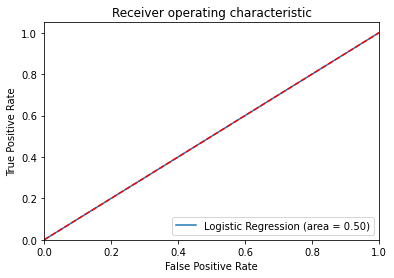

In [10]:
log_reg(X_train_25, y_train, X_val_25, y_val, X_test_25, y_test, "25th quantile")

# Modelling on 50th Quantile

In [11]:
## Load Datasets
X_train_50_path = "/Users/claudia/DSA4262-ACMXZ/data/preprocessed_data/X_train_50.parquet" ## to edit file path
X_train_50 = pd.read_parquet(X_train_50_path)

In [12]:
## check if training data are the same len
print(f"Number of Rows for X_train_50 and y_train: {len(X_train_50)}, {len(y_train)}")

## check if validation data are the same len
print(f"Number of Rows for X_val_50 and y_val: {len(X_val_50)}, {len(y_val)}")

## check if test data are the same len
print(f"Number of Rows for X_test_50 and y_test: {len(X_test_50)}, {len(y_test)}")

Number of Rows for X_train_50 and y_train: 51567, 51567
Number of Rows for X_val_50 and y_val: 17434, 17434
Number of Rows for X_test_50 and y_test: 16275, 16275


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy of logistic regression classifier on validation set using 50th quantile: 0.93
Accuracy of logistic regression classifier on test set using 50th quantile: 0.94


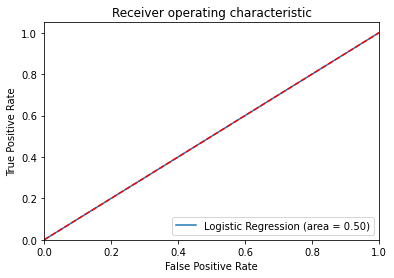

In [13]:
log_reg(X_train_50, y_train, X_val_50, y_val, X_test_50, y_test, "50th quantile")

# Modelling on 75th Quantile

In [14]:
## Load Datasets
X_train_75_path = "/Users/claudia/DSA4262-ACMXZ/data/preprocessed_data/X_train_75.parquet" ## to edit file path
X_train_75 = pd.read_parquet(X_train_75_path)

In [15]:
## check if training data are the same len
print(f"Number of Rows for X_train_75 and y_train: {len(X_train_75)}, {len(y_train)}")

## check if validation data are the same len
print(f"Number of Rows for X_val_75 and y_val: {len(X_val_75)}, {len(y_val)}")

## check if test data are the same len
print(f"Number of Rows for X_test_75 and y_test: {len(X_test_75)}, {len(y_test)}")

Number of Rows for X_train_75 and y_train: 51567, 51567
Number of Rows for X_val_75 and y_val: 17434, 17434
Number of Rows for X_test_75 and y_test: 16275, 16275


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy of logistic regression classifier on validation set using 75th quantile: 0.93
Accuracy of logistic regression classifier on test set using 75th quantile: 0.94


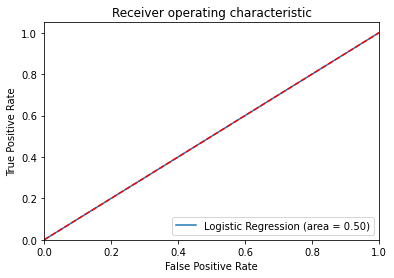

In [16]:
log_reg(X_train_75, y_train, X_val_75, y_val, X_test_75, y_test, "75th quantile")

# Modelling on Mean

In [ ]:
## Load Datasets
X_train_mean_path = "/Users/claudia/DSA4262-ACMXZ/data/preprocessed_data/X_train_mean.parquet" ## to edit file path
X_train_mean = pd.read_parquet(X_train_mean_path)

In [ ]:
## check if training data are the same len
print(f"Number of Rows for X_train_mean and y_train: {len(X_train_mean)}, {len(y_train)}")

## check if validation data are the same len
print(f"Number of Rows for X_val_mean and y_val: {len(X_val_mean)}, {len(y_val)}")

## check if test data are the same len
print(f"Number of Rows for X_test_mean and y_test: {len(X_test_mean)}, {len(y_test)}")

In [ ]:
log_reg(X_train_mean, y_train, X_val_mean, y_val, X_test_mean, y_test, "mean")

### Methods to improve accuracy

clustering certain variables

https://towardsdatascience.com/how-to-improve-the-accuracy-of-a-regression-model-3517accf8604

In [ ]:
### clustering

from sklearn.cluster import KMeans

## features that we want to consider when clustering
features = [] 

## fitting the cluster
kmeans = KMeans(n_cluster = 2) ## can edit the number of clusters
kmeans.fit(data[features])

## create a new column in data df to tell us which cluster it belongs to
data['cluster'] = kmeans.predict(data[features]) 

### Re-fit the Model

In [ ]:
## to define the variables used for prediction (X) and the result (y)

X = data[] 
y = data[] 

## split data into test and training set

X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(X, y, 
                                    test_size = 0.3, ## proportion of dataset to be used as test 
                                    random_state = 0) ## for reproducibility

In [ ]:
## fitting the model

logreg_cluster = LogisticRegression()
logreg_cluster.fit(X_train_cluster, y_train_cluster)

In [ ]:
## predicting test set result and calculating accuracy

y_pred_cluster = logreg_cluster.predict(X_test_cluster)
print('Accuracy of logistic regression classifier with clustering on test set: {:.2f}'.format(logreg_cluster.score(X_test_cluster, y_test_cluster)))

In [ ]:
## printing confusion matrix

confusion_matrix_cluster = confusion_matrix(y_test_cluster, y_pred_cluster)
print(confusion_matrix_cluster)

In [ ]:
## roc curve

logit_roc_auc_cluster = roc_auc_score(y_test_cluster, y_pred_cluster)

## fpr = false positive rate
## tpr = true positive rate
fpr_cluster, tpr_cluster, thresholds_cluster = roc_curve(y_test_cluster, logreg_cluster.predict_proba(X_test_cluster)[:,1])
plt.rc("font", size = 14)
plt.figure()
plt.plot(fpr_cluster, tpr_cluster, label = 'Logistic Regression Cluster (area = %0.2f)' % logit_roc_auc_cluster)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate with Clustering')
plt.ylabel('True Positive Rate with Clustering')
plt.title('Receiver operating characteristic with Clustering')
plt.legend(loc = "lower right")
plt.savefig('Log_ROC')
plt.show()